# Personality

## Intro
Blah

## Outline

* Problem at hand
* History
* Techniques with Factor rotation
* Comparrison with baseline Regressions
* Interpretation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [518]:
import personality
import factors
reload(personality)
reload(factors)
from personality import *
from factors import *

In [5]:
from factor_rotation._wrappers import rotate_factors

In [ ]:
X = prep_X(read_surveys())
bf_survey = X.iloc[:, 0:65]
bf_survey_scaled = pd.DataFrame(scale(bf_survey))
others = X.iloc[:, 65:]
others_scaled = pd.DataFrame(scale(others))
ids = read_surveys().user_id

# Get the big five components, sparse positie loadings for the questions that
# refer to personality traits. 
bigfive_key = pd.read_csv("educatalyst/Auxil/q1_key_bigfive.csv")
bf_comps = get_big_five_comps(bigfive_key)

# Projec the survey data onto those big five personality components
bigfive = big_five_projection(bigfive_key, bf_survey)
bigfive_scaled = big_five_projection(bigfive_key, bf_survey_scaled)

In [7]:
bigfive.to_csv("clean_data/bigfive.csv", index=False)
bf_survey.to_csv("clean_data/bigfive_survey.csv", index=False)
others.to_csv("clean_data/others.csv", index=False)

In [420]:
def get_projected_variance(df, comps, p = 5):
    projected = df.dot(normalize(comps).T)
    v =  np.var(projected)/np.var(df).sum() * 100 
    print 'Summed variance of first %s components: %s' % (p,v[0:p].sum())
    return v

def plot_corr(A, B):
    corr = np.corrcoef(F, bigfive, rowvar = False)
    p = sns.heatmap(pd.DataFrame(corr))
    plt.show()
    return p

In [9]:
# Variance described by pure PCA of others survey space
others_pca = PCA(5).fit(others_scaled)
# get_projected_variance(others, others_pca.components_)
A = others_pca.components_
V, T = rotate_factors(A.T, 'varimax')
np.stack([get_projected_variance(others_scaled, A), get_projected_variance(others_scaled, V.T)])

Summed variance of first 5 components: 46.0333921325
Summed variance of first 5 components: 46.0333921325


array([[ 18.40555681,  11.99694605,   6.14657412,   5.06260598,
          4.42170918],
       [ 13.9356478 ,   7.4355079 ,   7.79088151,   9.59363506,
          7.27771987]])

In [10]:
# projection of X into subspace of V
P = V.dot(V.T)
X_proj = others_scaled.dot(P)
np.allclose(X_proj, X_proj.dot(P))

bf_proj = bigfive.dot(bf_comps.T).shape

In [ ]:
others_pca = PCA(5).fit(others_scaled)

A = others_pca.components_
V, T = rotate_factors(A.T, 'varimax')
# V, T = rotate_factors(A.T, 'oblimin', .635, 'oblique')


# Comparing the LL' - \Psi to \Sigma! <-- error rate to optimize?? This is for orthogonality??
dif = np.cov(others_scaled.T) - V.dot(V.T)
off_diag = dif - np.diag(np.diag(dif))
print np.linalg.norm(np.cov(others_scaled.T)), np.linalg.norm(off_diag)

# np.diag(np.mean(F.dot(F.T)))
# others_scaled.dot(A.T)
# normalize(V)
# fit the form of Ax = B, we need to transpose everything from our basic X = FL' form
F = np.linalg.lstsq(V, others_scaled.T)[0].T

# Ratio norm of difference between projected others_scaled
print 1 - np.linalg.norm(others_scaled - F.dot(V.T))/np.linalg.norm(others_scaled)
# Ratio of variane between projected and others_scaled
print 1 - np.var(others_scaled - F.dot(V.T)).sum() / np.var(others_scaled).sum()

# This is only the same if we go with orthogonal factors!
# F = others_scaled.dot(V)

# Look at loadings matrix just like in Norman paper :D
print np.round(F * 100)

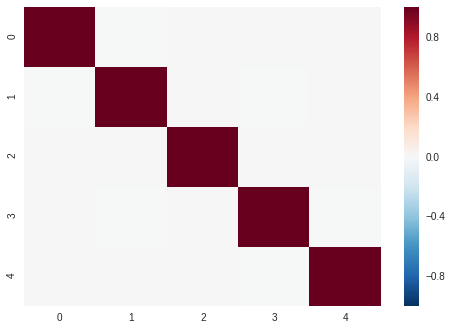

In [541]:
# In both cases, that of the big five survey and that of our others survey,
# there seems to be a single strong "general" component that is highly correlated
# with all the factors from the bigfive. This could definitely indicate a
# misspecification of the surveys themselves. 

bf_survey_pca = PCA(5).fit(bf_survey_scaled)
loadings = bf_survey_pca.components_.T
V, T = rotate_factors(loadings, 'varimax')
VO, T = rotate_factors(loadings, 'oblimin', .635, 'oblique')

corr = np.corrcoef(bf_survey_scaled.dot(loadings), bigfive, rowvar=False)
sns.heatmap(pd.DataFrame(corr).iloc[0:5,0:5])
plt.show()

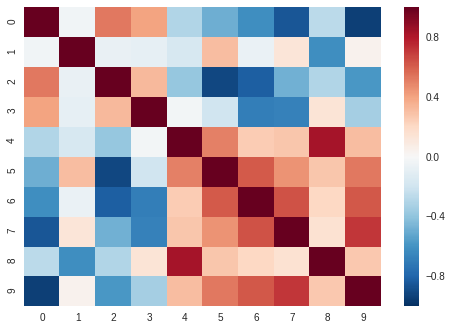

In [542]:
corr = np.corrcoef(bf_survey_scaled.dot(V), bigfive, rowvar=False)
sns.heatmap(pd.DataFrame(corr).iloc[0:10,0:10])
plt.show()

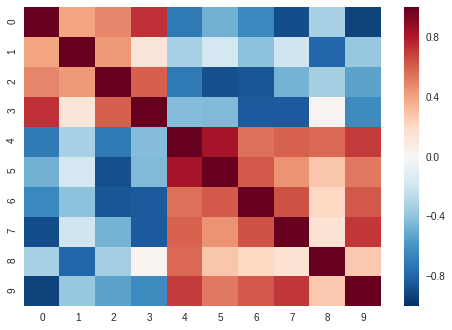

[ 0.32410222  0.17678225  0.34087297  0.03021434  0.83446009]


In [543]:
F = bf_survey_scaled.dot(VO)
plot_corr(F, bigfive)
print max_corr(F, bigfive)

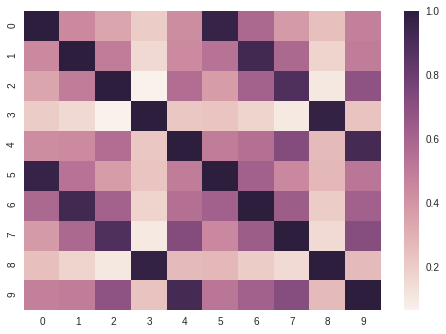

[ 0.96410928  0.92882687  0.88717368  0.97659425  0.92241772]


In [544]:
T = target_rotation(bf_survey_scaled.dot(V), bigfive)
F = bf_survey_scaled.dot(V.dot(T))

p = plot_corr(F, bigfive)
print max_corr(F, bigfive)

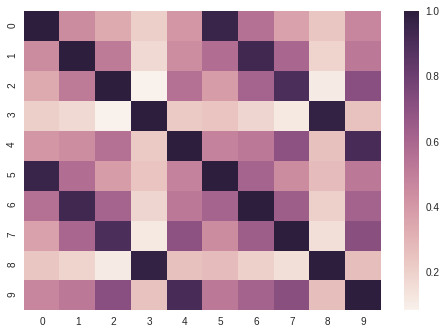

[ 0.95981849  0.93806137  0.89642417  0.97785646  0.91152155]


In [545]:
def ff(A, T, L=None):
    L = A.dot(T)
    # return np.linalg.norm(normalize(L) - np.array(bigfive_scaled))
    cor_sum = (max_corr(L, np.array(bigfive))).sum()
    return 1/cor_sum

T = target_rotation(bf_survey_scaled.dot(V), bigfive)
T = GPA(bf_survey_scaled.dot(V), ff, T = T, max_tries=2001)[2]
F = bf_survey_scaled.dot(V.dot(T))
plot_corr(F, bigfive)
print max_corr(F, bigfive)

In [ ]:
A = VO.dot(T)
T2 = target_rotation(bf_survey_scaled.dot(V), bigfive)
A2 = V.dot(T2)
print get_projected_variance(bf_survey, A.T)
print get_projected_variance(bf_survey, A2.T)
print get_projected_variance(bf_survey, bf_survey_pca.components_)
print get_projected_variance(bf_survey, bf_comps.T)

# print np.linalg.norm(normalize(bigfive) - normalize(bf_survey.dot(A)))
# print np.linalg.norm(normalize(bigfive))

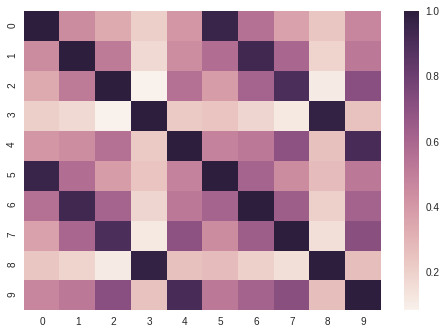

In [546]:
corr = np.corrcoef(F, bigfive, rowvar=False)
p = sns.heatmap(pd.DataFrame(corr))
plt.show()

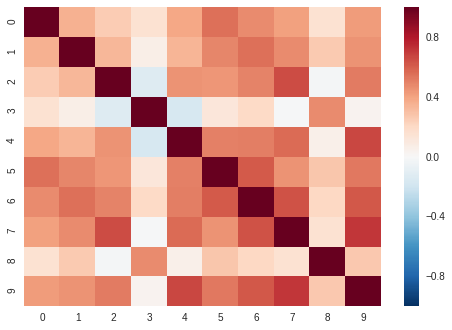

[ 0.55258204  0.54914326  0.6538904   0.47154529  0.6688041 ]


In [547]:
from factor_rotation._analytic_rotation import target_rotation
from factor_rotation._gpa_rotation import orthomax_objective

others_pca = PCA(5).fit(others_scaled)
A = others_pca.components_.T


# fn = lambda A: max_corr(A, bigfive).sum()
varimax = lambda A: orthomax_objective(L, gamma=1, return_gradient=False)
F = others_scaled.dot(A)
_,T = get_best_rotation(F, bigfive, target_rotation, varimax)
F = others_scaled.dot(A.dot(T))

plot_corr(F, bigfive)
print max_corr(F, bigfive)

In [550]:
from factor_rotation._gpa_rotation import GPA, rotateA as rotate

others_pca = PCA(5).fit(others_scaled)
A = others_pca.components_.T

def ff(A, T, L=None):
    V = rotate(A, T, 'oblique')
    F = np.linalg.lstsq(V, others_scaled.T)[0].T
    # return np.linalg.norm(normalize(L) - np.array(bigfive_scaled))
    cor_sum = (max_corr(F, bigfive)).sum()
    return 1/cor_sum

# create initial optimization target with orthogonal targeting
F = others_scaled.dot(A)
T = target_rotation(F, bigfive)

varimax = lambda A: orthomax_objective(L, gamma=1, return_gradient=False)

def get_rotation(A, H):
    F = others_scaled.dot(A)
    T = target_rotation(F, H)
    _,_,T,_ = GPA(A, ff, T=T, rotation_method='oblique')
    return T 

_,T = get_best_rotation(A, bigfive, get_rotation, varimax)
L = rotate(A, T, 'oblique')
F = np.linalg.lstsq(L, others_scaled.T)[0].T
corr = np.corrcoef(F, bigfive, rowvar = False)
sns.heatmap(corr)
plt.show()
max_corr(F, bigfive)

KeyboardInterrupt: 

In [ ]:
from scipy.spatial.distance import cosine, pdist, squareform
from factor_rotation._gpa_rotation import GPA


T = GPA(F, )
rotated_factors = F.dot(T)
# f,b = [np.array(df) for df in [rotated_factors, bigfive]]
# cos = squareform(pdist(np.concatenate([f.T,b.T]), 'cosine'))
# sns.heatmap(cos)
# plt.show()
# sum([cos[1,6], cos[2,7], cos[4,9], cos[3,8]])

In [ ]:
from sklearn.decomposition import DictionaryLearning

others_dict = DictionaryLearning(5).fit(others_scaled)

In [62]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components = 38)
res = cca.fit_transform(bf_survey, others)
bf_ccas = res[0]
others_ccas = res[1]
# get_projected_variance(bf_survey.T, bf_ccas.T), get_projected_variance(others.T, others_ccas.T)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_decomposition/pls_.py:83: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


In [25]:
F = others.dot(others_pca.components_.T)
# F.dot(others.T)
F.shape, others.shape

((94, 5), (94, 38))

In [280]:
# Variance described by Sparse PCA in others survey space
others_sparse_pca = SparsePCA(8, .8).fit(others)
get_projected_variance(others, others_sparse_pca.components_)

0    10.629493
1    10.414766
2     7.607404
3     5.766579
4     6.323208
5     5.765240
6     4.522215
7     7.120568
dtype: float64

Summed variance of first 5 components: 40.7414493917


### In the space of the Big Five survey:

In [ ]:
# Variance described by Big Five Regression from others survey space
get_projected_variance(others, enet.coef_)

In [ ]:
# Variance explained by official Big Five Mapping
get_projected_variance(bf_survey, bf_comps.T)

# varimax gives reasonable results here, leaves everything unchanged... 
# V,T = rotate_factors(bf_comps.T, 'varimax')
# bf_comps.T - V


In [91]:
# Variance explained by pure PCA
bf_survey_pca = PCA(5).fit(bf_survey)
# get_projected_variance(bf_survey, bf_survey_pca.components_)
A = bf_survey_pca.components_
V, _ = rotate_factors(A, 'varimax')
# get_projected_variance(bf_survey, V)
# np.round(V*10000)

In [283]:
# Variance explained by Sparse PCA
bf_survey_sparse_pca = SparsePCA(8, .8).fit(bf_survey)
get_projected_variance(bf_survey, bf_survey_sparse_pca.components_)

0     6.954491
1    12.506588
2     5.411025
3     9.582842
4     7.341020
5     6.396424
6     4.112881
7     7.628662
dtype: float64

Summed variance of first 5 components: 41.7959663825


In [154]:
from factor_rotation._gpa_rotation import GPA
a = np.array([[0.01,1.0], [1,0.01]])
b = np.array([[-1.0,0.01], [0.01, 1.0]])

def ff(A, T, L=None):
    # print "translate"
    # print T
    L = A.dot(T)
    # print L
    p = (L).dot(b.T).sum()
    # print p
    return 1/p

a = GPA(a, ff, max_tries = 2001)
np.round(a[0])

array([[-1.,  0.],
       [ 0.,  1.]])